# Installing Necssary Libraries

In [ ]:
!pip install tensorflow

# Preprocessing the data

Importing the necessary libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

Using the fashion-mnsit datset to train

In [ ]:
train = pd.read_csv("/content/fashion-mnist_train.csv")
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dropping the label column as it is not necessary

In [ ]:
train = train.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1)

Visualizing the data

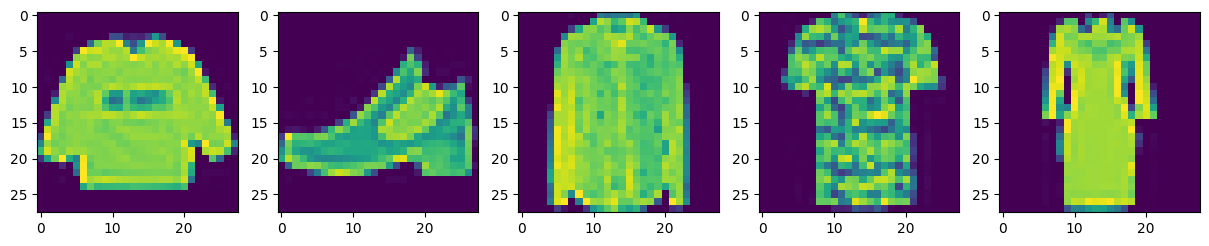

In [ ]:
fig,axes = plt.subplots(1,5,figsize=(15,15))
for index,x in enumerate(train[:5]):
    axes[index].imshow(x)

Creating a preprocessing pipeline for easy use of data in tensorflow using tf.data

In [ ]:
def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images

#converting numpy array to tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices({'image':train})
#Once converted to tensorflow dataset, map() acts as apply() used in dataframe in python i.e. mapping each entry to a function
dataset = dataset.map(preprocess)
#repeat(3): repeat the dataset thrice. No number means infinite
#shuffle(100): shuffle the dataset using 100 as buffer_size
#batch(128): divide dataset in batches of 128 elements each
#prefetch(1): prefetch 1 batch in advance before getting requested hence reducing latency
dataset = dataset.repeat(3).shuffle(100).batch(128).prefetch(1)

In [ ]:
print(dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


Declaring a few variables

In [ ]:
input_shape = (28,28,1)
final_encoder_dim = 2
decoder_input_dim = 4
depth = 5
kernel_size = 3
activation = 'tanh'
dropout = 0.1

# Designing the GAN models

Designing Discriminator

In [ ]:
def discriminator(input_shape, dim, depth, kernel, dropout,activation):
    layers = []
    layers.append(InputLayer(input_shape=input_shape))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel_size))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(128,activation='relu'))
    layers.append(Dense(dim))
    return Sequential(layers)

encoder = discriminator(input_shape, final_encoder_dim, depth, kernel_size, dropout,activation)

*  The InputLayer() intakes the input_shape i.e. 28x28x1. This layer acts as a placeholder for actual input
*  Then we add a Convolution layer followed by BatchNormalization, ReLU activation & Dropout multiple times in the same sequence depending upon the depth required (here it is 5)
*  The rest of the code is similar to any CNN

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 16)        0         
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                        

# Designing Generator

In [ ]:
def generator(input_shape, depth, output_shape,kernel,dropout):
    layers = []
    layers.append(InputLayer(input_shape=(input_shape,)))
    layers.append(Dense(784,activation='relu'))
    layers.append(Reshape(target_shape=output_shape))
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))

    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [28,28]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(1,kernel_size=1,activation=None))
    return Sequential(layers)
decoder = generator(decoder_input_dim, depth, input_shape,kernel_size,dropout)

* InputLayer() intaking input_shape equal to (4,) in our case. This can be of any dimension
* The Dense layer is used to map this lower dimension a higher dimension & the high dimension embedding is then reshaped
* Similar to Discriminator, depending upon the depth, a similar code block is appended except the Conv2D layer is replaced by Conv2DTranspose which is more of an inverse Conv2D layer upsampling the data unlike Conv2D that downsamples the image.

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 784)               3920      
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 16)       160       
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 30, 16)        0         
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 16)       

Defining the loss function & optimizers for the 2 networks

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
encoder_opt = tf.keras.optimizers.Adam()
decoder_opt = tf.keras.optimizers.Adam()

# Training

The training is broken down in to three phases


1.   Batch Training
2.   Epoch Training
3.   Complete Training



In [ ]:
def training(training_data):
    batch_size = tf.shape(training_data)[0]
    real_data = training_data
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    labels = tf.concat((real_labels,fake_labels),axis=0)
    noise = tf.random.normal((batch_size,decoder_input_dim),mean=0,stddev=1)

    with tf.GradientTape() as decoder_gt, tf.GradientTape() as encoder_gt:

        fake_images = decoder(noise,training=True)
        fake_labels_2 = encoder(fake_images,training=True)
        real_labels_2 = encoder(training_data,training=True)
        predicted_labels = tf.concat((real_labels_2,fake_labels_2),axis=0)


        discrim_loss = loss(labels,predicted_labels)
        #print(discrim_loss)
        gen_loss = loss(real_labels,fake_labels_2)

    dec_grad = decoder_gt.gradient(gen_loss,decoder.trainable_variables)
    enc_grad = encoder_gt.gradient(discrim_loss,encoder.trainable_variables)

    decoder_opt.apply_gradients(zip(dec_grad, decoder.trainable_variables))
    encoder_opt.apply_gradients(zip(enc_grad, encoder.trainable_variables))

    return discrim_loss, gen_loss

In [ ]:
import os
def epoch_training(data_iterator, steps_per_epoch, avg_gen_loss, avg_dis_loss):
  try:
      for x in range(steps_per_epoch):
          d_loss, g_loss = training(next(data_iterator))
          avg_gen_loss.update_state(g_loss)
          avg_dis_loss.update_state(d_loss)
          if x%20==0:
              print('{} steps done'.format(x))

      gen_loss = avg_gen_loss.result()
      dis_loss = avg_dis_loss.result()


      tf.summary.scalar('gen_loss',gen_loss,step=encoder_opt.iterations)
      tf.summary.flush()
      tf.summary.scalar('dis_loss',dis_loss,step=decoder_opt.iterations)
      tf.summary.flush()

      avg_gen_loss.reset_state()
      avg_dis_loss.reset_state()
      return gen_loss.numpy(), dis_loss.numpy()

  except StopIteration:
        print('End of dataset reached.')
        return 0.0, 0.0

def train(training_data, epochs):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=decoder_opt,discriminator_optimizer=encoder_opt,generator=decoder,discriminator=encoder)
    manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint)

    summary = tf.summary.create_file_writer('metrics/train')

    avg_generator_loss = tf.keras.metrics.Mean()
    avg_discriminator_loss = tf.keras.metrics.Mean()

    data_iterator = training_data.__iter__()
    for i in range(epochs):
        with summary.as_default():
            gen_loss, dis_loss = epoch_training(data_iterator, 100, avg_generator_loss, avg_discriminator_loss)
            print({'gen_loss':gen_loss,'dis_loss':dis_loss})
            manager.save()

Training the dataset

In [ ]:
train(dataset,100)

0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 8.093697, 'dis_loss': 0.023775171}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 8.90657, 'dis_loss': 0.013535567}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 9.028268, 'dis_loss': 0.006603058}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 8.922433, 'dis_loss': 0.16274342}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 6.2652416, 'dis_loss': 0.027568117}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 6.9898505, 'dis_loss': 0.017363453}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 8.116298, 'dis_loss': 0.015741577}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 8.796931, 'dis_loss': 0.0074791647}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps

# Generating new images

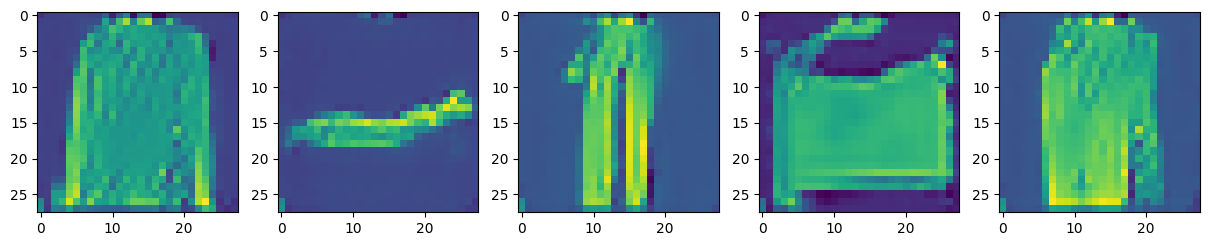

In [ ]:
noise = tf.random.normal((5,4),mean=0,stddev=1)
images = decoder(noise,training=False)
fig,axes = plt.subplots(1,5,figsize=(15,15))
for index,x in enumerate(images):
    axes[index].imshow(x)
